In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c worcap-2025
!unzip worcap-2025.zip -d worcap-2025
!pip install torch
!pip install rasterio
!pip install spyndex
!pip uninstall -y torch torchvision torchaudio
!pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Saving kaggle.json to kaggle.json
 74% 214M/290M [00:00<00:00, 764MB/s] 
100% 290M/290M [00:00<00:00, 706MB/s]
Archive:  worcap-2025.zip
  inflating: worcap-2025/dataset_kaggle/avaliacao/t1/recorte_1.tif  
  inflating: worcap-2025/dataset_kaggle/avaliacao/t1/recorte_10.tif  
  inflating: worcap-2025/dataset_kaggle/avaliacao/t1/recorte_100.tif  
  inflating: worcap-2025/dataset_kaggle/avaliacao/t1/recorte_101.tif  
  inflating: worcap-2025/dataset_kaggle/avaliacao/t1/recorte_102.tif  
  inflating: worcap-2025/dataset_kaggle/avaliacao/t1/recorte_103.tif  
  inflating: worcap-2025/dataset_kaggle/avaliacao/t1/recorte_104.tif  
  inflating: worcap-2025/dataset_kaggle/avaliacao/t1/recorte_105.tif  
  inflating: worcap-2025/dataset_kaggle/avaliacao/t1/recorte_106.tif  
  inflating: worcap-2025/dataset_kaggle/avaliacao/t1/recorte_107.tif  
  inflating: worcap-2025/dataset_kaggle/avaliacao/t1/recorte_108.tif  
  inflating: worcap-2025/dataset_kaggle/avaliacao/t1/recorte_109.tif  
  inflating: w

In [2]:
# bibliotecas de visualizaçÃo de dados
import os
import numpy as np
import csv
#bibliotecas de aprendizado de máquina
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,random_split
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
# biblioteca para lidar com dados geoespaciais
import rasterio
from rasterio import plot
import spyndex
import matplotlib.pyplot as plt
import csv
import random

rgb_path_1 = "/content/worcap-2025/dataset_kaggle/dataset/t1/recorte_30.tif"
rgb_path_2 = "/content/worcap-2025/dataset_kaggle/dataset/t2/recorte_30.tif"
mask_path = "/content/worcap-2025/dataset_kaggle/dataset/mask/recorte_30.tif"


Tamanho do dataset completo: 945
Tamanho do treino (80%): 756
Tamanho da validação (20%): 189
Usando dispositivo: cuda
Epoch 1/49 -> Train Loss: 0.1226 | Validation Loss: 0.0602
Epoch 2/49 -> Train Loss: 0.0542 | Validation Loss: 0.0444
Epoch 3/49 -> Train Loss: 0.0406 | Validation Loss: 0.0351
Epoch 4/49 -> Train Loss: 0.0361 | Validation Loss: 0.0408
Epoch 5/49 -> Train Loss: 0.0357 | Validation Loss: 0.0293
Epoch 6/49 -> Train Loss: 0.0324 | Validation Loss: 0.0313
Epoch 7/49 -> Train Loss: 0.0312 | Validation Loss: 0.0295
Epoch 8/49 -> Train Loss: 0.0316 | Validation Loss: 0.0646
Epoch 9/49 -> Train Loss: 0.0338 | Validation Loss: 0.0286
Epoch 10/49 -> Train Loss: 0.0302 | Validation Loss: 0.0268
Epoch 11/49 -> Train Loss: 0.0272 | Validation Loss: 0.0250
Epoch 12/49 -> Train Loss: 0.0291 | Validation Loss: 0.0275
Epoch 13/49 -> Train Loss: 0.0307 | Validation Loss: 0.0299
Epoch 14/49 -> Train Loss: 0.0316 | Validation Loss: 0.0259
Epoch 15/49 -> Train Loss: 0.0269 | Validation Los

/tmp/ipython-input-1365013962.py:181: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



--- Relatório de Classificação ---
              precision    recall  f1-score   support

Não Queimado       0.99      1.00      1.00   3058296
    Queimado       0.76      0.49      0.60     38280

    accuracy                           0.99   3096576
   macro avg       0.88      0.74      0.80   3096576
weighted avg       0.99      0.99      0.99   3096576

Resultado Final -> AUC-ROC: 0.9842


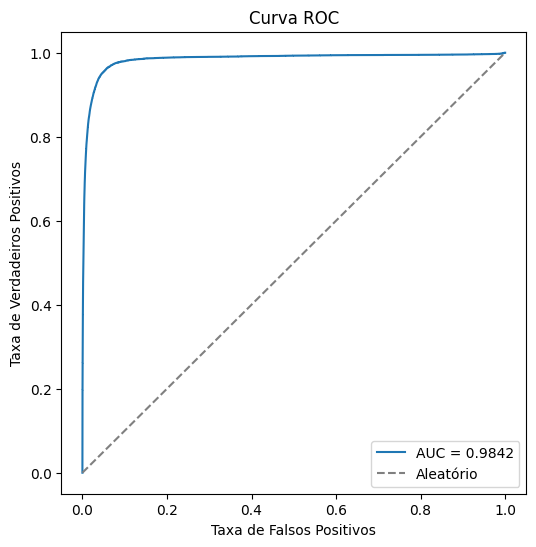


Visualizando 5 exemplos aleatórios de predição...


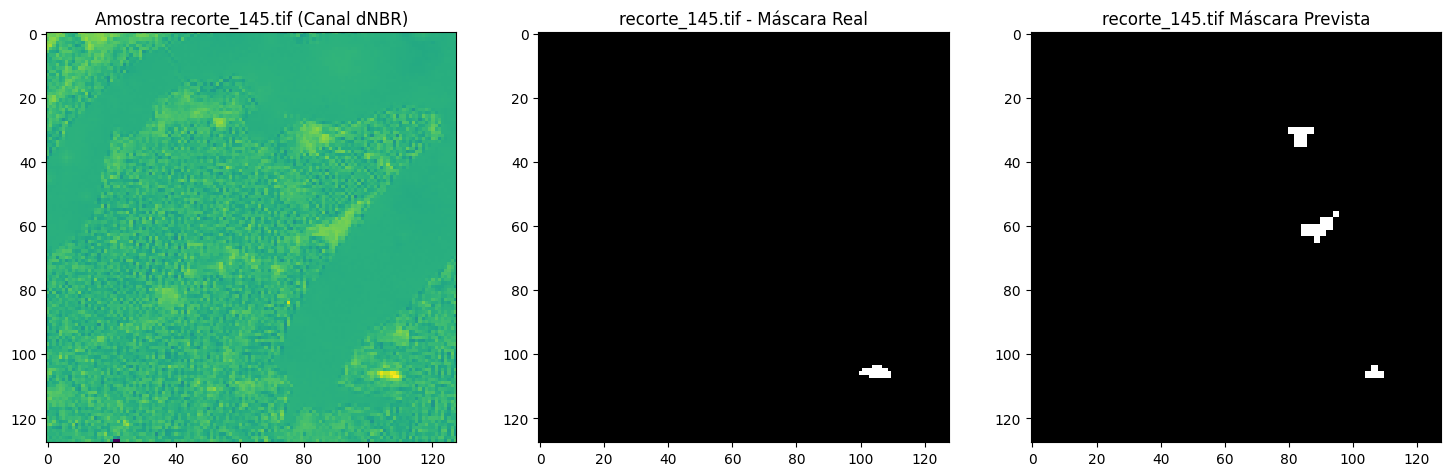

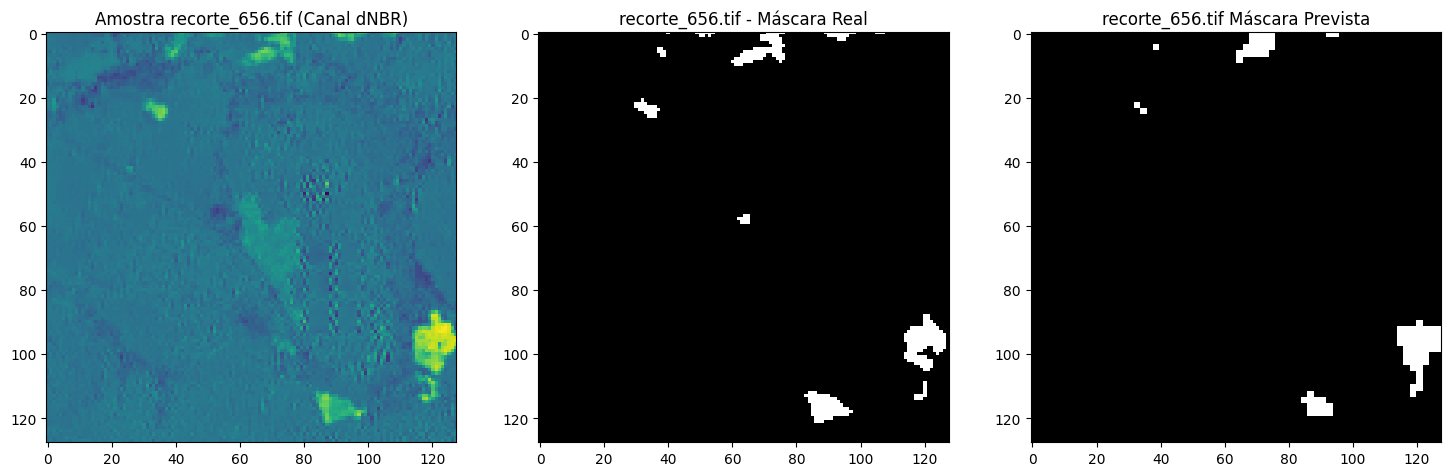

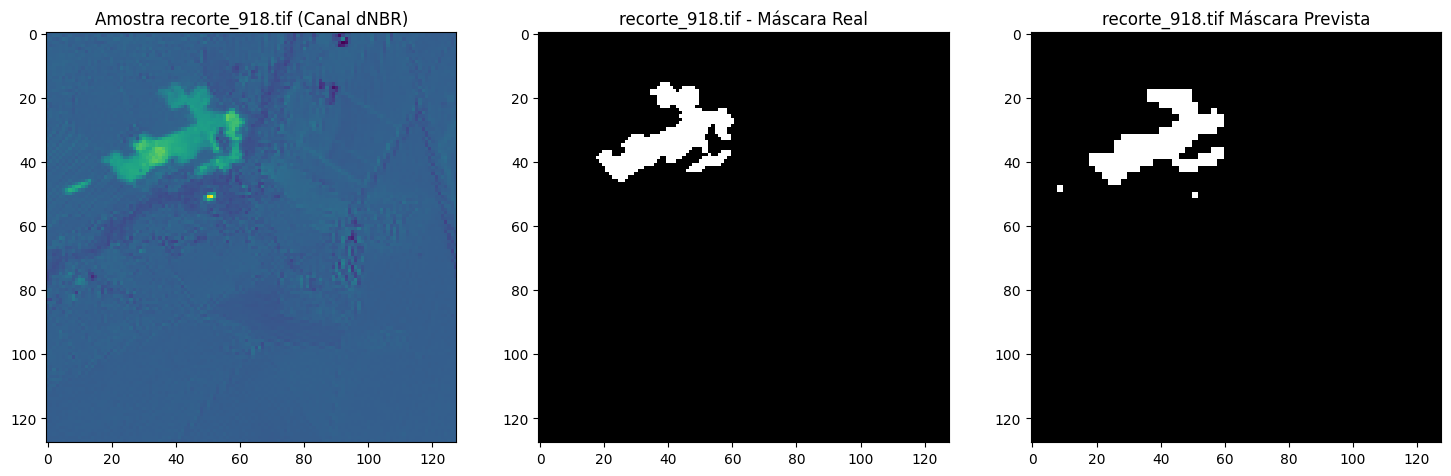

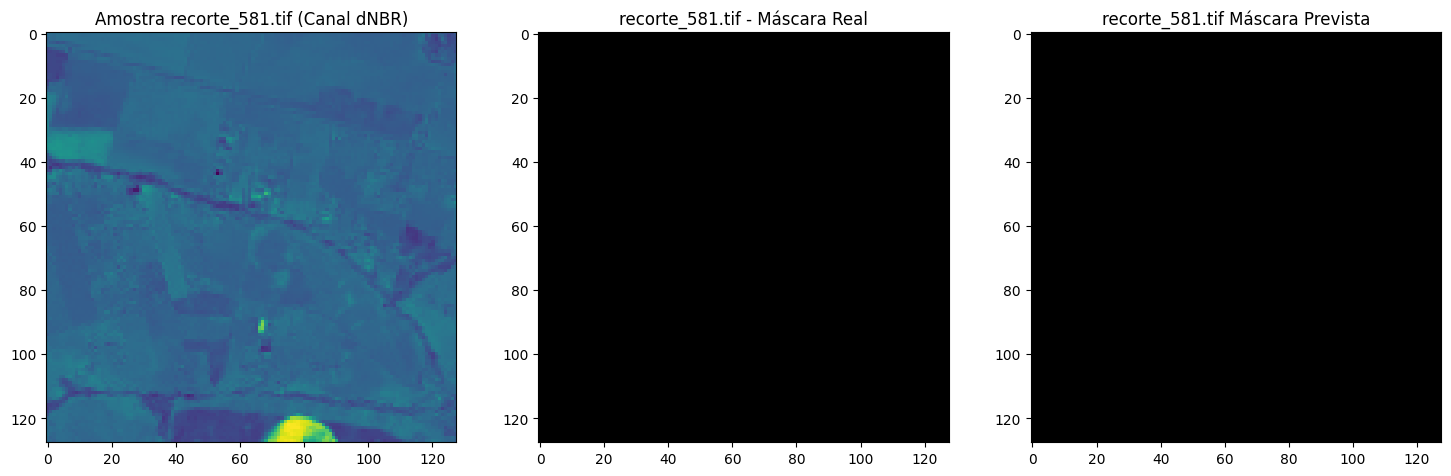

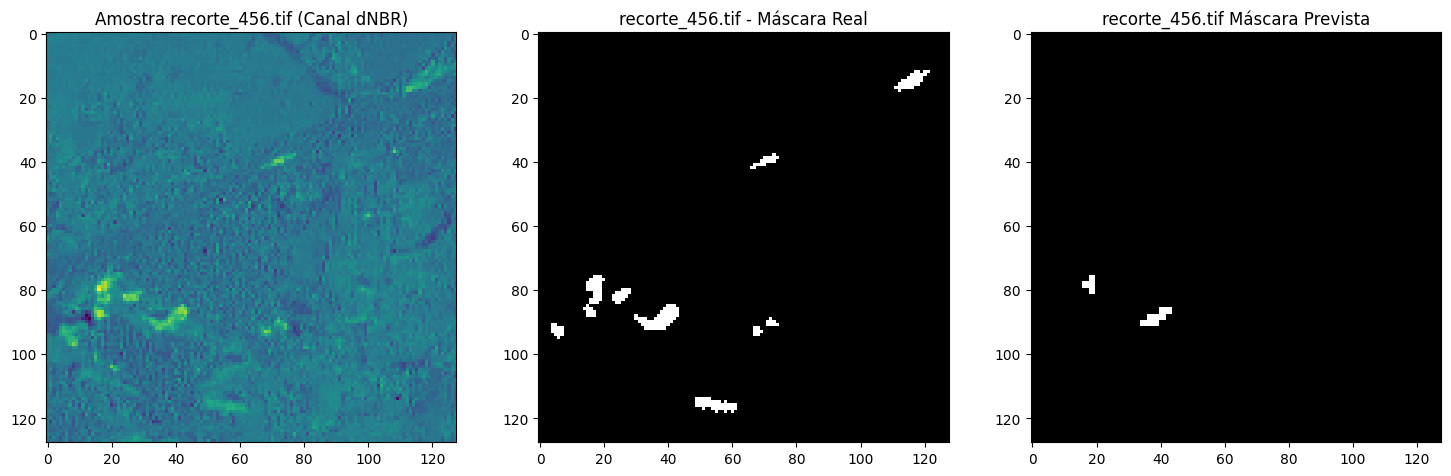

In [3]:
class ChangeIndexDataset(Dataset):
    def __init__(self, T1_dir, T2_dir, mask_dir, transform=None):
        self.T1_dir = T1_dir
        self.T2_dir = T2_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.ids = sorted([
            f.split('_')[-1].replace('.tif', '')
            for f in os.listdir(T1_dir)
            if f.startswith('recorte_') and
               os.path.isfile(os.path.join(T2_dir, f)) and
               os.path.isfile(os.path.join(mask_dir, f))
        ])

    def __len__(self):
        return len(self.ids)

    def calculate_indices(self, path):
        """Lê uma imagem e calcula NBR e NDVI."""
        with rasterio.open(path) as src:
            # Bandas: 1(RED), 2(NIR), 3(SWIR1), 4(SWIR2)
            red = src.read(1).astype(np.float32)
            nir = src.read(2).astype(np.float32)
            swir2 = src.read(4).astype(np.float32)

        np.seterr(divide='ignore', invalid='ignore')

        nbr = spyndex.computeIndex(index=["NBR"], params={"N": nir, "S2": swir2})
        ndvi = spyndex.computeIndex(index=["NDVI"], params={"N": nir, "R": red})

        # Substitui NaN por 0
        nbr = np.nan_to_num(nbr, nan=0.0)
        ndvi = np.nan_to_num(ndvi, nan=0.0)

        return nbr, ndvi

    def read_mask(self, path):
        with rasterio.open(path) as src:
            mask = src.read(1).astype(np.float32)
            mask = np.nan_to_num(mask, nan=0.0)
            mask = np.where(mask > 0, 1.0, 0.0)
        return torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

    def __getitem__(self, idx):
        id_ = self.ids[idx]
        fname = f"recorte_{id_}.tif"
        T1_path = os.path.join(self.T1_dir, fname)
        T2_path = os.path.join(self.T2_dir, fname)
        mask_path = os.path.join(self.mask_dir, fname)

        # Calcula índices para T1 e T2
        nbr1, ndvi1 = self.calculate_indices(T1_path)
        nbr2, ndvi2 = self.calculate_indices(T2_path)

        # Calcula a diferença
        dNBR = nbr1 - nbr2
        dNDVI = ndvi1 - ndvi2

        # Empilha os deltas para criar uma imagem de 2 canais
        change_image = np.stack([dNBR, dNDVI], axis=0)

        # Normalização simples para o intervalo [-1, 1]
        # dNBR e dNDVI variam de -2 a 2. Dividir por 2 os coloca em [-1, 1]
        change_image = change_image / 2.0

        change_tensor = torch.tensor(change_image, dtype=torch.float32)

        mask = self.read_mask(mask_path)

        if self.transform:
            change_tensor = self.transform(change_tensor)
            mask = self.transform(mask)
        return change_tensor, mask

class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            DoubleConv(2, 64),
            nn.MaxPool2d(2),
            DoubleConv(64, 128),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            DoubleConv(128, 128),
            nn.Upsample(scale_factor=2),
            DoubleConv(128, 64),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        f = self.encoder(x)
        out = self.decoder(f)
        return out

def train(model, train_loader, val_loader, device, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCELoss()
    for epoch in range(epochs):
        # --- Loop de Treino ---
        model.train()
        total_train_loss = 0
        for change_image, mask in train_loader:
            change_image, mask = change_image.to(device), mask.to(device)
            pred = model(change_image)
            loss = criterion(pred, mask)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # --- Loop de Validação ---
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for change_image, mask in val_loader:
                change_image, mask = change_image.to(device), mask.to(device)
                pred = model(change_image)
                loss = criterion(pred, mask)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{epochs} -> Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")

    torch.save(model.state_dict(), "unet_indices_model.pth")
    print("✅ Modelo salvo como 'unet_indices_model.pth'")


def evaluate_model(model_path, dataloader, device):
    """
    Carrega o melhor modelo, avalia no conjunto de dados fornecido (validação/teste),
    e plota a curva ROC-AUC e um exemplo de predição.
    """
    # Carrega a arquitetura do modelo e os pesos salvos
    model = UNet()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval() # Coloca o modelo em modo de avaliação

    all_labels = []
    all_preds = []

    print("\nIniciando avaliação final no conjunto de validação...")
    with torch.no_grad():
        for change_image, mask in dataloader:
            change_image = change_image.to(device)
            pred = model(change_image)

            # Achata os resultados para o cálculo da curva ROC
            all_labels.extend(mask.numpy().ravel())
            all_preds.extend(pred.cpu().numpy().ravel())

    # --- Calcular e plotar AUC-ROC ---
    auc = roc_auc_score(all_labels, all_preds)
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds)

    # Binariza as predições de probabilidade usando um limiar de 0.5
    all_preds_binary = (np.array(all_preds) > 0.5).astype(int)

    print("\n--- Relatório de Classificação ---")
    # target_names: 0 é 'Não Queimado', 1 é 'Queimado'
    print(classification_report(all_labels, all_preds_binary, target_names=['Não Queimado', 'Queimado']))

    print(f"Resultado Final -> AUC-ROC: {auc:.4f}")

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0,1], [0,1], linestyle="--", color="gray", label="Aleatório")
    plt.xlabel("Taxa de Falsos Positivos")
    plt.ylabel("Taxa de Verdadeiros Positivos")
    plt.title("Curva ROC")
    plt.legend()
    plt.show()

    print("\nVisualizando 5 exemplos aleatórios de predição...")
    num_samples = len(dataloader.dataset)
    sample_indices = random.sample(range(num_samples), 5)

    for index in sample_indices:
        if hasattr(dataloader.dataset, "indices"):  # Subset
            original_idx = dataloader.dataset.indices[index]
            file_id = dataloader.dataset.dataset.ids[original_idx]
        else:
            file_id = dataloader.dataset.ids[index]
        file_name = f"recorte_{file_id}.tif"
        change_image, mask = dataloader.dataset[index]
        with torch.no_grad():
            pred = model(change_image.unsqueeze(0).to(device))
        pred_mask = pred.squeeze(0).cpu().detach().numpy()
        original_mask = mask.squeeze(0).cpu().numpy()
        dnbr_channel = change_image.squeeze(0)[0].cpu().numpy()

        pred_mask_binary = (pred_mask > 0.5).astype(np.float32)

        fig, ax = plt.subplots(1, 3, figsize=(18, 6))
        ax[0].imshow(dnbr_channel, cmap='viridis')
        ax[0].set_title(f"Amostra {file_name} (Canal dNBR)")

        ax[1].imshow(original_mask.squeeze(), cmap='gray')
        ax[1].set_title(f"{file_name} - Máscara Real")

        ax[2].imshow(pred_mask_binary.squeeze(), cmap='gray')
        ax[2].set_title(f"{file_name} Máscara Prevista")

        plt.show()

rgb_path_1 = "/content/worcap-2025/dataset_kaggle/dataset/t1"
rgb_path_2 = "/content/worcap-2025/dataset_kaggle/dataset/t2"
mask_path = "/content/worcap-2025/dataset_kaggle/dataset/mask"


full_dataset = ChangeIndexDataset(rgb_path_1, rgb_path_2, mask_path)

# Define o tamanho dos conjuntos de treino (80%) e validação (20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Divide o dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

print(f"Tamanho do dataset completo: {len(full_dataset)}")
print(f"Tamanho do treino (80%): {len(train_dataset)}")
print(f"Tamanho da validação (20%): {len(val_dataset)}")

# Cria os DataLoaders para cada conjunto
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Configura dispositivo e modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

model = UNet()

# Chama a função de treino com os dois DataLoaders
train(model, train_loader, val_loader, device, epochs=51)
evaluate_model("unet_indices_model.pth", val_loader, device)

In [4]:

# Caminhos das pastas de avaliação
t1_dir = "/content/worcap-2025/dataset_kaggle/avaliacao/t1"
t2_dir = "/content/worcap-2025/dataset_kaggle/avaliacao/t2"

def calculate_indices(path):
    """Lê uma imagem e calcula NBR e NDVI."""
    with rasterio.open(path) as src:
        red = src.read(1).astype(np.float32)
        nir = src.read(2).astype(np.float32)
        swir2 = src.read(4).astype(np.float32)
    np.seterr(divide='ignore', invalid='ignore')
    nbr = spyndex.computeIndex(index=["NBR"], params={"N": nir, "S2": swir2})
    ndvi = spyndex.computeIndex(index=["NDVI"], params={"N": nir, "R": red})
    nbr = np.nan_to_num(nbr, nan=0.0)
    ndvi = np.nan_to_num(ndvi, nan=0.0)
    return nbr, ndvi

# Listar arquivos
files_t1 = sorted([f for f in os.listdir(t1_dir) if f.endswith('.tif')])
files_t2 = sorted([f for f in os.listdir(t2_dir) if f.endswith('.tif')])
assert len(files_t1) == len(files_t2), "⚠️ T1 e T2 têm número diferente de arquivos!"

csv_path = "predicted_change_masks.csv"

with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)

    # Escreve o cabeçalho do CSV
    # Pega o tamanho da imagem do primeiro arquivo
    with rasterio.open(os.path.join(t1_dir, files_t1[0])) as src:
        num_pixels = src.width * src.height
    header = ["id"] + [f"pixel_{i}" for i in range(num_pixels)]
    writer.writerow(header)

    print(f"Iniciando predições para {len(files_t1)} imagens...")
    # Iterar sobre todos os pares T1/T2
    for idx, (f1, f2) in enumerate(zip(files_t1, files_t2)):
        id_sample = os.path.splitext(f1)[0].replace("_", "")+".tif"

        # --- Lógica de pré-processamento para a UNet ---
        T1_path = os.path.join(t1_dir, f1)
        T2_path = os.path.join(t2_dir, f2)

        nbr1, ndvi1 = calculate_indices(T1_path)
        nbr2, ndvi2 = calculate_indices(T2_path)

        dNBR = nbr1 - nbr2
        dNDVI = ndvi1 - ndvi2

        change_image = np.stack([dNBR, dNDVI], axis=0)
        change_image = change_image / 2.0 # Normalização

        # Converte para tensor e envia para o dispositivo
        change_tensor = torch.tensor(change_image, dtype=torch.float32).unsqueeze(0).to(device)

        # Predição da máscara
        with torch.no_grad():
            pred_logits = model(change_tensor)
            pred_proba = torch.sigmoid(pred_logits) # Aplica sigmoid pois o modelo retorna logits
            pred_mask = (pred_proba > 0.5).int().cpu().numpy().flatten() # Binariza e achata

        # Escrever linha no CSV
        row = [id_sample] + pred_mask.tolist()
        writer.writerow(row)

        if (idx + 1) % 50 == 0:
            print(f"  ... {idx + 1}/{len(files_t1)} imagens processadas.")

print(f"✅ Máscaras preditas salvas em '{csv_path}'")

Iniciando predições para 315 imagens...
  ... 50/315 imagens processadas.
  ... 100/315 imagens processadas.
  ... 150/315 imagens processadas.
  ... 200/315 imagens processadas.
  ... 250/315 imagens processadas.
  ... 300/315 imagens processadas.
✅ Máscaras preditas salvas em 'predicted_change_masks.csv'
